PyTorch training loop and Testing loop

For the training loop, we'll build the following steps:

    Forward pass
    Calculate the loss
    Zero gradients
    Perform backpropagation on the loss
    Update the optimizer (gradient descent)



In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
torch.manual_seed(42) #For Reproducibility

In [3]:
def generate_data(n=200):
    X = np.linspace(0, 20, num=n)
    y = X + 2 * np.sin(X) + np.random.normal(scale=0.5, size=X.shape)
    return X.reshape(-1, 1).astype(np.float32), y.reshape(-1, 1).astype(np.float32)

In [4]:
class Simple1DRegressionDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        # Zero mean, unit variance
        self.X = (X - X.mean()) / X.std()
        self.X = torch.from_numpy(self.X.astype(np.float32))
        self.y = torch.from_numpy(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [5]:
class DynamicMLP(nn.Module):
    def __init__(self, inp, hid, op, dropout=0.0, activation=nn.LeakyReLU):
        super().__init__()
        layers = []
        dims = [inp] + hid
        for in_dim, out_dim in zip(dims[:-1], dims[1:]):
            layers += [
                nn.Linear(in_dim, out_dim),
                nn.BatchNorm1d(out_dim),
                activation(negative_slope=0.1),
                nn.Dropout(dropout)
            ]
        layers += [nn.Linear(dims[-1], op)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [6]:
X, y = generate_data()
dataset = Simple1DRegressionDataset(X, y)
loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [7]:
hidden_layers = [128] * 11
model = DynamicMLP(inp=1, hid=hidden_layers, op=1, dropout=0.0)
print(model.net) # I tried couple of different architectures to try make the fit line better

Sequential(
  (0): Linear(in_features=1, out_features=128, bias=True)
  (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.1)
  (3): Dropout(p=0.0, inplace=False)
  (4): Linear(in_features=128, out_features=128, bias=True)
  (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): LeakyReLU(negative_slope=0.1)
  (7): Dropout(p=0.0, inplace=False)
  (8): Linear(in_features=128, out_features=128, bias=True)
  (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): LeakyReLU(negative_slope=0.1)
  (11): Dropout(p=0.0, inplace=False)
  (12): Linear(in_features=128, out_features=128, bias=True)
  (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): LeakyReLU(negative_slope=0.1)
  (15): Dropout(p=0.0, inplace=False)
  (16): Linear(in_features=128, out_features=128, bias=True)
  (17): BatchNorm1d(128, eps=1e-05,

In [8]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
def train(model, loader, loss_fn, optimizer, epochs=1000, device='cpu'):
    model.to(device)
    history = []
    for epoch in tqdm(range(epochs), desc='Training'):
        total_loss = 0.0
        model.train()
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        history.append(total_loss)
    return history

Training: 100%|██████████| 1700/1700 [01:09<00:00, 24.34it/s]


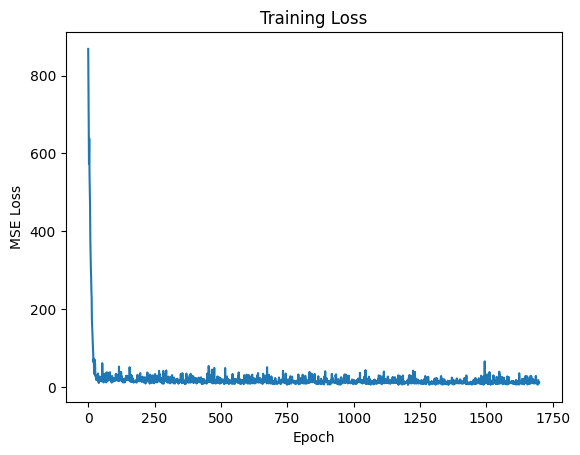

In [10]:
ehist = train(model, loader, loss_fn, optimizer, epochs=1700, device=device)
plt.figure()
plt.plot(ehist)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.show()

In [11]:
model.eval()
with torch.no_grad():
    X_norm = (X - X.mean()) / X.std()
    X_tensor = torch.from_numpy(X_norm.astype(np.float32)).to(device)
    y_pred = model(X_tensor).cpu().numpy().ravel()

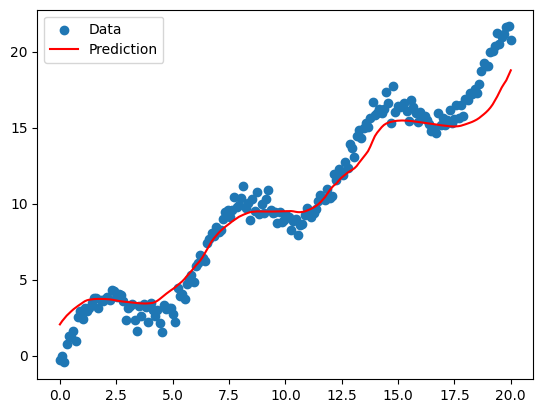

In [12]:
plt.figure()
plt.scatter(X, y, label='Data')
plt.plot(X.ravel(), y_pred, color='red', label='Prediction')
plt.legend()
plt.show()